In [1]:
# 1.目的
# 直近騎手複勝指数について、過去何回分の平均値が適切なのか調べたい
# 2.やったこと
# XGBoostを使う。目的変数を着番とし、説明変数を直近騎手複勝率（平均50,60,70,80,90,100回）とする。それぞれの変数重要度を計算する

In [3]:
# インポート
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score

In [15]:
# CSVファイルの読み込み、23-24年に絞る
df = pd.read_csv('input_編集後_50-100.csv', encoding='utf-8')
print(f"dfの行数は {len(filtered_df)} ")
filtered_df = df[df['race_id'].astype(str).str[:2].isin(['23', '24'])]
filtered_df = filtered_df[filtered_df['jockey_place_rate_5'].notna()]
print(f"jockey_place_rate_5が欠損していない行数は {len(filtered_df)} ")

dfの行数は 21711 
jockey_place_rate_5が欠損していない行数は 21711 


In [ ]:
# 回帰の場合→XGBRegressorを使う

In [9]:
# 説明変数
x = filtered_df[["jockey_place_rate_0",
        "jockey_place_rate_1",
        "jockey_place_rate_2",
        "jockey_place_rate_3",
        "jockey_place_rate_4",
        "jockey_place_rate_5"
       ]]
# 目的変数
y = filtered_df["finish_rank"]
# 学習データと検証データの分割
filtered_df.loc[:, 'race_id_year'] = filtered_df['race_id'].astype(str).str[:2]
year_filtered_df = filtered_df[filtered_df['race_id_year'].isin(['23', '24'])]
count_23 = (year_filtered_df['race_id_year'] == '23').sum()
count_24 = (year_filtered_df['race_id_year'] == '24').sum()
rate_24 = count_24 / (count_23 + count_24)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=rate_24, shuffle=False)
# データが正常かを確認（欠損値の有無など）
print("NaN の数:", y_train.isna().sum())
print("inf の数:", np.isinf(y_train).sum())
print("y_train のデータ型:", y_train.dtype)
# モデルの学習
model = xgb.XGBRegressor(objective='reg:squarederror', max_depth=3, random_state=42)
model.fit(x_train, y_train)
# 予測
y_pred = model.predict(x_test)
# 評価
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")

NaN の数: 0
inf の数: 0
y_train のデータ型: int64
RMSE: 2.2465
R^2 Score: 0.0394


In [7]:
# 説明変数の重要度を示す

               Feature  Importance
5  jockey_place_rate_5    0.463707
4  jockey_place_rate_4    0.144359
1  jockey_place_rate_1    0.118088
2  jockey_place_rate_2    0.092801
3  jockey_place_rate_3    0.092540
0  jockey_place_rate_0    0.088506


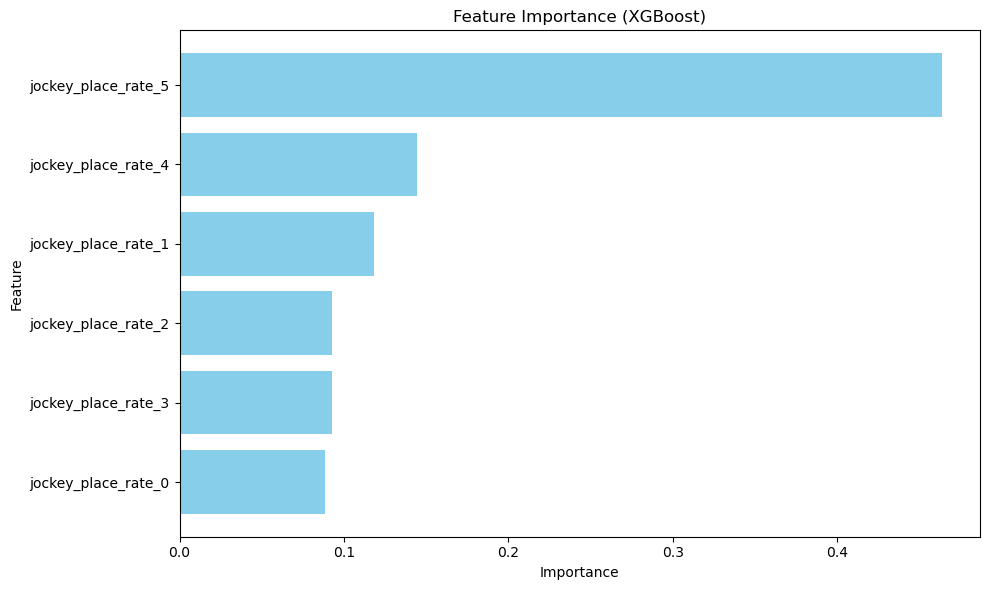

In [11]:
import matplotlib.pyplot as plt

# 特徴量名と重要度を取得
feature_names = x.columns
feature_importances = model.feature_importances_
# DataFrameで整形して、重要度順にソート
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
# 結果を表示（数値）
print(importances_df)
# 可視化（棒グラフ）
plt.figure(figsize=(10, 6))
plt.barh(importances_df['Feature'], importances_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (XGBoost)')
plt.gca().invert_yaxis()  # 重要度が高いものを上に
plt.tight_layout()
plt.show()